# LiH ~ oo-pUCCD 

Determino l'initial point dei primi (8) parametri del circuito $\ket{\text{pUCCD}}$ eseguendo una prima volta VQE. 
Dopodiché le alternative sono due:
- fissare i primi parametri e ottimizzare solo i (15) $k$ orbitali
- ottimizzare ogni volta tutti i parametri

in questo programma si adotta la prima strategia. 
Il tempo di esecuzione è di circa 1 ora.

In [3]:
from functools import partial 
from time import time
import matplotlib.pyplot as plt
from pyscf import scf, fci

from subroutines import *

# Array distanze e energie
arr_distance = np.arange(0.8, 3.95, 0.45) # (0.75, 4., 0.65) così sono 5 punti; (0.8, 4., 0.2) ~28 min
arr_ground_energy = {
    'FCI': [],
    'pUCCD': [],
    'oo-pUCCD': []
}


In [ ]:
for distance in arr_distance:
    
    print('- - - - - - - - - - - -', distance, '- - - - - - - - - - - -')
    # 0: FCI
    LiH = "Li 0 0 0; H 0 0 " + str(distance)
    basis = 'sto3g'
    
    ''' Integrals'''
    mol = gto.M(atom=LiH, basis=basis)

    cm  = scf.RHF(mol)
    cm.kernel() 
    fci_calc = fci.FCI(cm)
    e_FCI = fci_calc.kernel()[0]
    arr_ground_energy['FCI'].append(e_FCI)
    
    two_electron_integrals = mol.intor('int2e') # , aosym='s8') opzioni di simmetria
    one_electron_integrals = mol.intor("int1e_kin") + mol.intor("int1e_nuc")
    
    # 1: pUCCD
    problem = generate_problem(LiH, basis)
    puccd = generate_puccd(problem)
    puccd_result = compute_puccd_optimal(puccd, problem) 
    # and assign parameters
    assigned_puccd = puccd.assign_parameters(puccd_result.optimal_parameters)
    puccd_interpreted = problem.interpret(puccd_result)
    puccd_energy = puccd_interpreted.groundenergy + puccd_interpreted.nuclear_repulsion_energy
    arr_ground_energy['pUCCD'].append(puccd_energy)
    
    # 2: oo-pUCCD
    rotations = create_orbital_rotation_list(puccd)
    excitations = convert_rotations_list(rotations)
    oo_puccd = generate_oo_puccd(assigned_puccd, problem, excitations)

    # SOLVE
    vqe_solver = VQE(Estimator(), oo_puccd, SLSQP())
    vqe_solver.initial_point = [0.0] * oo_puccd.num_parameters

    energy_evaluation = partial(energy_evaluation_oo, 
                                problem, 
                                one_electron_integrals,
                                two_electron_integrals,
                                vqe_solver, 
                                rotations, 
                                0)

    ini = [ 3.23322778e-02,  4.36404671e-04,  1.37779855e-07,  3.96951039e-08,
        -7.88745039e-04, -4.05058769e-02,  9.88076074e-10,  2.84742901e-10,
            1.33658206e-02, -1.34882454e-11, -3.81397555e-12, -3.84563936e-01,
        -2.76888454e-14,  7.94063378e-12,  2.26076217e-12 ]

    # setto bounds default
    bounds = [ [-2*np.pi,2*np.pi] for _ in range(oo_puccd.num_parameters) ]

    start_time = time()
    
    # minimization
    opt_result = vqe_solver.optimizer.minimize(
        fun=energy_evaluation, x0=ini, bounds=bounds
    )
        
    eval_time = time() - start_time
    
    result = VQEResult()
    result.optimal_point = opt_result.x
    result.optimal_parameters = dict(zip(vqe_solver.ansatz.parameters, opt_result.x))
    result.optimal_value = opt_result.fun
    result.cost_function_evals = opt_result.nfev
    result.optimizer_time = eval_time
    result.eigenvalue = opt_result.fun + 0j
    
    oo_interpreted = problem.interpret(result)
    oo_energy = oo_interpreted.groundenergy + oo_interpreted.nuclear_repulsion_energy
    
    arr_ground_energy['oo-pUCCD'].append(oo_energy)
    
    

plot

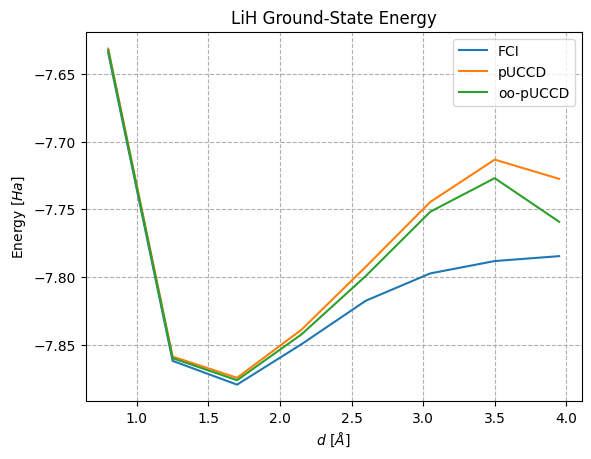

In [5]:
    
method = ['FCI', 'pUCCD', 'oo-pUCCD']

for met in method:  
    plt.plot(arr_distance, arr_ground_energy[met], label=met)

plt.title("LiH Ground-State Energy")
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Energy $[Ha]$")
plt.grid(linestyle='--')
plt.legend()
plt.show()